In [1]:
import os
from collections import defaultdict
from tqdm import tqdm

import torch
from collections import defaultdict

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    balanced_accuracy_score,
    classification_report,
    confusion_matrix,
)
from sklearn.preprocessing import normalize
from CLIP.clip import clip

import math


In [2]:
from prompts.prompts_taxonomia import prompts_Animal, prompts_Order_stingray, prompts_Order_shark, prompts_Family_cacharhiniformes, prompts_Our_Name_scyliorhinidae, prompts_Our_Name_triakidae

In [3]:
data = [
    ['bocanegra','galeus melastomus','blackmouth catshark','carcharhiniformes','scyliorhinidae','shark'],
    ['cazon','galeorhinus galeus','tope shark','carcharhiniformes','triakidae','shark'],
    ['cerdo_marino','oxynotus centrina','angular roughshark','squaliformes','oxynotidae','shark'],
    ['musola','mustelus mustelus','smouth-hound','carcharhiniformes','triakidae','shark'],
    ['pintarroja','scyliorhinus canicula','small-spotted catshark','carcharhiniformes','scyliorhinidae','shark'],
    ['santiaguesa','raja undulata','undulate ray','rajiformes','rajidae','stingray'],
    ['tembladera','torpedo marmorata','spotted torpedo','torpediniformes','torpedinidae','stingray'],
]

df = pd.DataFrame(data, columns=['Our_Name','Scientific Name', 'Common Name', 'Order', 'Family','Animal']) 
df

Our_Name        Scientific Name             Common Name  \
0     bocanegra      galeus melastomus     blackmouth catshark   
1         cazon     galeorhinus galeus              tope shark   
2  cerdo_marino      oxynotus centrina      angular roughshark   
3        musola      mustelus mustelus            smouth-hound   
4    pintarroja  scyliorhinus canicula  small-spotted catshark   
5   santiaguesa          raja undulata            undulate ray   
6    tembladera      torpedo marmorata         spotted torpedo   

               Order          Family    Animal  
0  carcharhiniformes  scyliorhinidae     shark  
1  carcharhiniformes       triakidae     shark  
2       squaliformes      oxynotidae     shark  
3  carcharhiniformes       triakidae     shark  
4  carcharhiniformes  scyliorhinidae     shark  
5         rajiformes         rajidae  stingray  
6    torpediniformes    torpedinidae  stingray

In [4]:
from PIL import Image

def resize_con_padding(img, target_size=(224, 224), fill_color=(255, 255, 255)):
    """
    Reescala la imagen manteniendo el aspecto y la centra en un lienzo cuadrado con padding.
    
    Args:
        img: PIL.Image
        target_size: tamaño final (ancho, alto)
        fill_color: color del fondo (por defecto blanco)
    
    Returns:
        PIL.Image redimensionada sin distorsión
    """
    img_ratio = img.width / img.height
    target_ratio = target_size[0] / target_size[1]

    if img_ratio > target_ratio:
        new_width = target_size[0]
        new_height = round(new_width / img_ratio)
    else:
        new_height = target_size[1]
        new_width = round(new_height * img_ratio)

    img_resized = img.resize((new_width, new_height), resample=Image.BICUBIC)

    new_img = Image.new("RGB", target_size, fill_color)
    upper_left = ((target_size[0] - new_width) // 2, (target_size[1] - new_height) // 2)
    new_img.paste(img_resized, upper_left)

    return new_img


In [5]:

main_folder = r'D:\datasets\ELASMOBRANC\data'

image_paths_shark = []
labels_shark = []
exclude_classes=[]

for class_name in os.listdir(main_folder):
    if any(excl in class_name.lower() for excl in exclude_classes):
        continue  
    class_folder = os.path.join(main_folder, class_name)
    if os.path.isdir(class_folder):
        for item_name in os.listdir(class_folder):
            item_path = os.path.join(class_folder, item_name)
            if os.path.isfile(item_path):
                image_paths_shark.append(item_path)
                labels_shark.append(class_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-L/14', device)

imagens_tensor = []
for r in image_paths_shark:
    image = Image.open(r)
    image = resize_con_padding(image) 
    image_input = preprocess(image).unsqueeze(0).to(device)
    imagens_tensor.append(image_input)
    
batch_images = torch.cat(imagens_tensor, dim=0)
with torch.no_grad():
  feature_image_all = model.encode_image(batch_images)
  feature_image=feature_image_all[:,0,:]

In [6]:
all_prompts = {
    "Animal": prompts_Animal,
    "Order_raya": prompts_Order_stingray,
    "Order_shark": prompts_Order_shark,
    "Family_cacharhiniformes": prompts_Family_cacharhiniformes,
    "Our_Name_scyliorhinidae": prompts_Our_Name_scyliorhinidae,
    "Our_Name_triakidae": prompts_Our_Name_triakidae,
}

encoded_dict = {}

for group_key, prompt_dict in all_prompts.items():
    for key, descriptions in prompt_dict.items():
        if key not in encoded_dict:
            encoded_dict[key] = []
        for desc in descriptions:
            text_input = clip.tokenize(desc).to(device)
            with torch.no_grad():
                text_feat = model.encode_text(text_input)
            text_feat /= text_feat.norm(dim=-1, keepdim=True)

            encoded_dict[key].append({
                "description": desc,
                "text_embedding": text_feat,
                "group": group_key
            })



In [7]:
df_clean = df[['Animal','Order','Family','Our_Name']]
df_taxonomy = df_clean.sort_values(by=['Animal','Order','Family','Our_Name']).reset_index(drop=True)
df_taxonomy


Animal              Order          Family      Our_Name
0     shark  carcharhiniformes  scyliorhinidae     bocanegra
1     shark  carcharhiniformes  scyliorhinidae    pintarroja
2     shark  carcharhiniformes       triakidae         cazon
3     shark  carcharhiniformes       triakidae        musola
4     shark       squaliformes      oxynotidae  cerdo_marino
5  stingray         rajiformes         rajidae   santiaguesa
6  stingray    torpediniformes    torpedinidae    tembladera

In [8]:
orders_shark = df_taxonomy.loc[df_taxonomy["Animal"] == "shark", "Order"].unique().tolist()
orders_shark

['carcharhiniformes', 'squaliformes']

In [9]:
levels=["Animal","Order","Family","Our_Name"]
label_animal=["shark","stingray"]

final_results=[]

for image in feature_image:
    result_image=[]
    
    img_norm = image / image.norm(dim=-1, keepdim=True)
    
    shark_emb = encoded_dict["shark"][0]["text_embedding"].flatten()
    stingray_emb = encoded_dict["stingray"][0]["text_embedding"].flatten()
    
    sims_animal = (img_norm @ torch.stack([shark_emb, stingray_emb]).T).squeeze(0)
    result_image.append(label_animal[sims_animal.argmax().item()])
    
    i=0
    while i<len(levels)-1:     
        next_level = df_taxonomy.loc[df_taxonomy[levels[i]] == result_image[-1], levels[i+1]].unique().tolist()
        if len(next_level) == 1:
            result_image.append(next_level[0])
            i += 1
            continue         
        embs_text = torch.stack([encoded_dict[k][0]["text_embedding"].flatten() for k in next_level])        
        sims = (img_norm @ embs_text.T).squeeze(0)
        result_image.append(next_level[sims.argmax().item()])
        i += 1

    final_results.append(result_image)
    

-----Animal-----
Accuracy balanced: 0.9880
Accuracy: 0.9888

Classification Report:
               precision    recall  f1-score   support

       shark       0.99      0.99      0.99       308
    stingray       0.98      0.99      0.98       140

    accuracy                           0.99       448
   macro avg       0.99      0.99      0.99       448
weighted avg       0.99      0.99      0.99       448



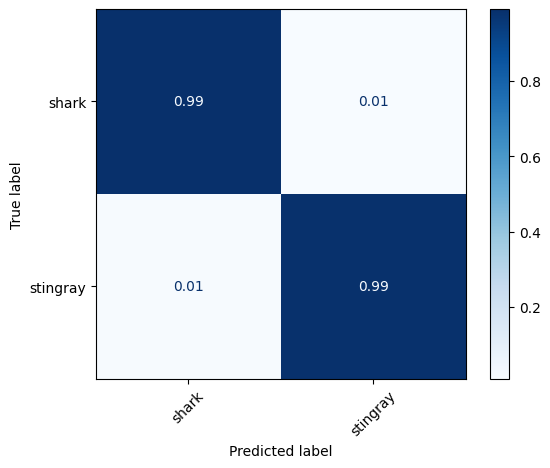


-----Order-----
Accuracy balanced: 0.8277
Accuracy: 0.8214

Classification Report:
                    precision    recall  f1-score   support

carcharhiniformes       0.99      0.82      0.89       272
     squaliformes       0.38      0.86      0.53        36
       rajiformes       0.86      0.83      0.85        90
  torpediniformes       0.74      0.80      0.77        50

         accuracy                           0.82       448
        macro avg       0.74      0.83      0.76       448
     weighted avg       0.89      0.82      0.84       448



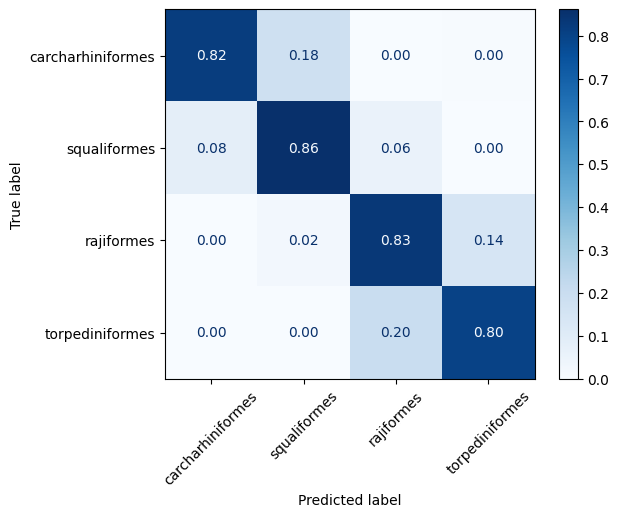


-----Family-----
Accuracy balanced: 0.7791
Accuracy: 0.7545

Classification Report:
                 precision    recall  f1-score   support

scyliorhinidae       0.91      0.73      0.81       158
     triakidae       0.78      0.67      0.72       114
    oxynotidae       0.38      0.86      0.53        36
       rajidae       0.86      0.83      0.85        90
  torpedinidae       0.74      0.80      0.77        50

      accuracy                           0.75       448
     macro avg       0.73      0.78      0.73       448
  weighted avg       0.81      0.75      0.77       448



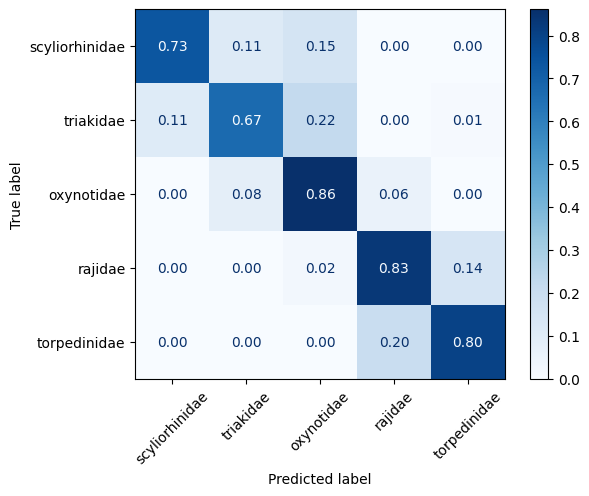


-----Our_Name-----
Accuracy balanced: 0.6210
Accuracy: 0.6049

Classification Report:
               precision    recall  f1-score   support

   bocanegra       0.26      0.51      0.35        37
       cazon       0.70      0.37      0.48        38
cerdo_marino       0.38      0.86      0.53        36
      musola       0.56      0.57      0.56        76
  pintarroja       0.89      0.40      0.56       121
 santiaguesa       0.86      0.83      0.85        90
  tembladera       0.74      0.80      0.77        50

    accuracy                           0.60       448
   macro avg       0.63      0.62      0.58       448
weighted avg       0.70      0.60      0.61       448



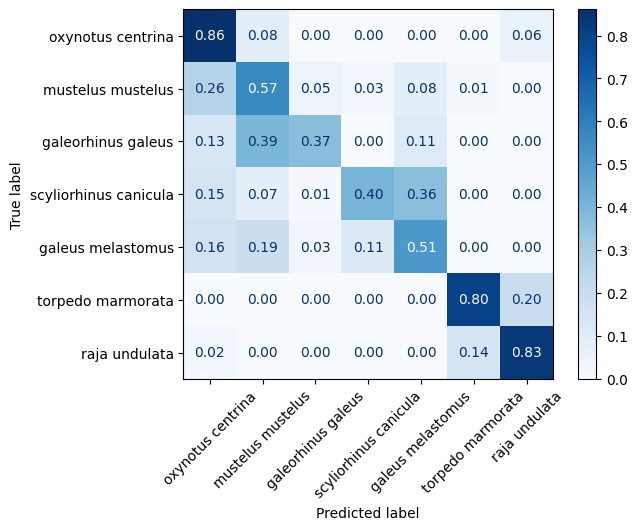

In [10]:
labels_shark_True = [label.lower() for label in labels_shark]

desired_order_display = [
    "oxynotus centrina",
    "mustelus mustelus",
    "galeorhinus galeus",
    "scyliorhinus canicula",
    "galeus melastomus",
    "torpedo marmorata",
    "raja undulata"
]

typo_fix = {}

for v, lv in enumerate(levels):
    col = [row[v] for row in final_results]
    name_to_level = dict(zip(df["Our_Name"], df[lv]))
    labels_shark_adt = [name_to_level[name] for name in labels_shark_True]

    print("-----" + lv + "-----")
    acc = balanced_accuracy_score(labels_shark_adt, col)
    print(f"Accuracy balanced: {acc:.4f}")
    acc = accuracy_score(labels_shark_adt, col)
    print(f"Accuracy: {acc:.4f}")
    report = classification_report(
        labels_shark_adt,
        col,
        labels=df[lv].drop_duplicates().to_list(),
        zero_division=0
    )
    print("\nClassification Report:\n", report)

    if v == len(levels) - 1:
        level_to_scientific = dict(zip(df[lv], df["Scientific Name"]))
        scientific_to_level = {s: l for l, s in level_to_scientific.items()}

        desired_order_corrected = [typo_fix.get(s, s) for s in desired_order_display]
        ordered_lv_labels = [scientific_to_level[s] for s in desired_order_corrected]

        cm = confusion_matrix(
            labels_shark_adt,
            col,
            labels=ordered_lv_labels,
            normalize="true"
        )
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=desired_order_display)
    else:
        cm = confusion_matrix(
            labels_shark_adt,
            col,
            labels=df[lv].drop_duplicates().to_list(),
            normalize="true"
        )
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=df[lv].drop_duplicates().to_list())

    disp.plot(cmap="Blues", xticks_rotation=45, values_format=".2f")
    plt.show()
    print()


## Prototype-guided weights

In [11]:

main_folder = r'D:\datasets\ELASMOBRANC\A_SISTEMATICAS'

esquema_paths_shark = []
esquema_labels_shark = []
nombres_archivos=[]

exclude_classes = []

for class_name in os.listdir(main_folder):
    if any(excl in class_name.lower() for excl in exclude_classes):
        continue  

    class_folder = os.path.join(main_folder, class_name)

    if os.path.isdir(class_folder):
        for img_name in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_name)
            if os.path.isfile(img_path):
                esquema_paths_shark.append(img_path)
                esquema_labels_shark.append(class_name)
                nombres_archivos.append(img_name)
                
    

In [12]:

batch_images_esquema = torch.cat([
    preprocess(resize_con_padding(Image.open(r))).unsqueeze(0)
    for r in esquema_paths_shark
], dim=0).to(device)

with torch.no_grad():
    feature_image_esquema = model.encode_image(batch_images_esquema)
feature_image_esquema /= feature_image_esquema.norm(dim=-1, keepdim=True)


In [13]:
global_img_features=[]
spatial_img_features=[]

global_sch_features=[]
spatial_sch_features=[]


for t in feature_image_all:
    global_img_features.append(t[0, :])
    spatial_img_features.append(t[1:, :])

for t in feature_image_esquema:
    global_sch_features.append(t[0, :])
    spatial_sch_features.append(t[1:, :])


In [14]:
global_sch_features = torch.stack(global_sch_features)     # (N, D)
spatial_sch_features = torch.stack(spatial_sch_features)   # (N, P, D)

global_by_species = defaultdict(list)
spatial_by_species = defaultdict(list)

for g, s, label in zip(global_sch_features, spatial_sch_features, esquema_labels_shark):
    global_by_species[label].append(g)   # (D,)
    spatial_by_species[label].append(s)  # (P, D)

global_sch_means = {}
spatial_sch_means = {}

for label, feats in global_by_species.items():
    stacked = torch.stack(feats, dim=0)     # (num_imgs_label, D)
    global_sch_means[label] = stacked.mean(dim=0)  # (D,)

for label, feats in spatial_by_species.items():
    stacked = torch.stack(feats, dim=0)     # (num_imgs_label, P, D)
    spatial_sch_means[label] = stacked.mean(dim=0)  # (P, D)


In [15]:
labels_sorted = sorted(global_sch_means.keys())

global_means_tensor = torch.stack([global_sch_means[label] for label in labels_sorted])      # (S, D)
spatial_means_tensor = torch.stack([spatial_sch_means[label] for label in labels_sorted])    # (S, P, D)

In [16]:
def get_imgAtt_multiQ(key_paths, queries):
    with torch.no_grad():
        maps = []
        for feat_v in tqdm(key_paths):
            scores = torch.matmul(feat_v, queries.T) * 1
            scores = scores.max(dim=0, keepdim=True).values - scores
            
            A_weight = torch.softmax(scores, dim=-1)

            maps.append(A_weight.T)
        return torch.stack(maps)


In [17]:
A_weight = get_imgAtt_multiQ(spatial_img_features, (global_means_tensor))


100%|██████████| 448/448 [00:00<00:00, 7860.25it/s]


In [18]:
def _to_pil(img, size):
    if isinstance(img, torch.Tensor):
        img = img.detach().cpu()
        if img.ndim == 3 and img.shape[0] in (1, 3):
            img = img.permute(1, 2, 0).numpy()
        else:
            img = img.numpy()
    if isinstance(img, np.ndarray):
        if img.dtype != np.uint8:
            img = (np.clip(img, 0, 1) * 255).astype(np.uint8)
        img = Image.fromarray(img)
    return img.resize((size, size))

def show_att(A_weight, real_images, image_id=0, queries=None, size=224, cmap='jet', add_colorbar=False):
    A = torch.stack(A_weight) if isinstance(A_weight, list) else A_weight
    image_id = max(0, min(int(image_id), A.shape[0]-1, len(real_images)-1))
    M, N = A.shape[1], A.shape[2]
    mesh = int(math.isqrt(N))
    qs = range(M) if queries is None else [q for q in queries if 0 <= q < M]
    img_pil = _to_pil(real_images[image_id], size)

    A_img = A[image_id]
    local_min = A_img.min().item()
    local_max = A_img.max().item()
    denom = (local_max - local_min + 1e-8)

    for q in qs:
        att = A_img[q].detach().float().cpu().reshape(mesh, mesh)
        att = (att - local_min) / denom
        att_resized = F.interpolate(att[None, None], size=(size, size), mode='bilinear', align_corners=False).squeeze().numpy()
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(img_pil); axs[0].set_title(f"Image #{image_id}"); axs[0].axis('off')
        axs[1].imshow(img_pil)
        im = axs[1].imshow(att_resized, cmap=cmap, alpha=0.5, vmin=0.0, vmax=1.0)
        axs[1].set_title(f"Query #{q}"); axs[1].axis('off')
        if add_colorbar:
            cbar = fig.colorbar(im, ax=axs.ravel().tolist(), orientation='vertical', fraction=0.025, pad=0.02)
            cbar.set_label('Attention (norm.)')
        plt.tight_layout()
        plt.show()

      


In [19]:
imagenes_reales= []

for i in batch_images:
    img = i.detach().cpu().permute(1, 2, 0).numpy()
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    imagenes_reales.append(img)

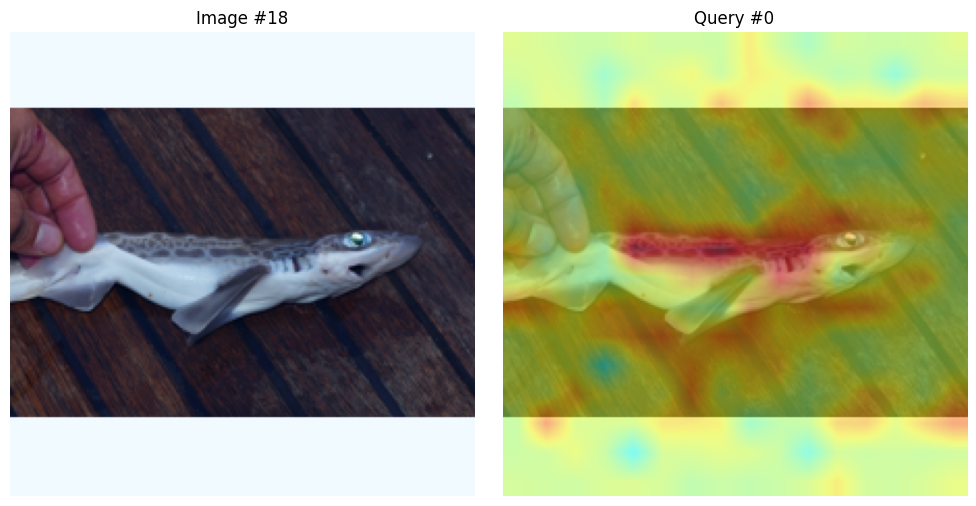

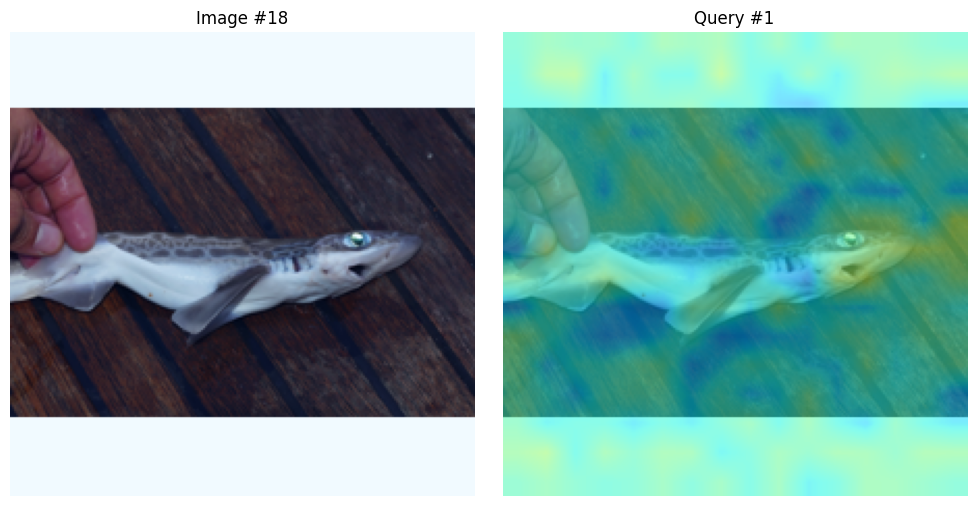

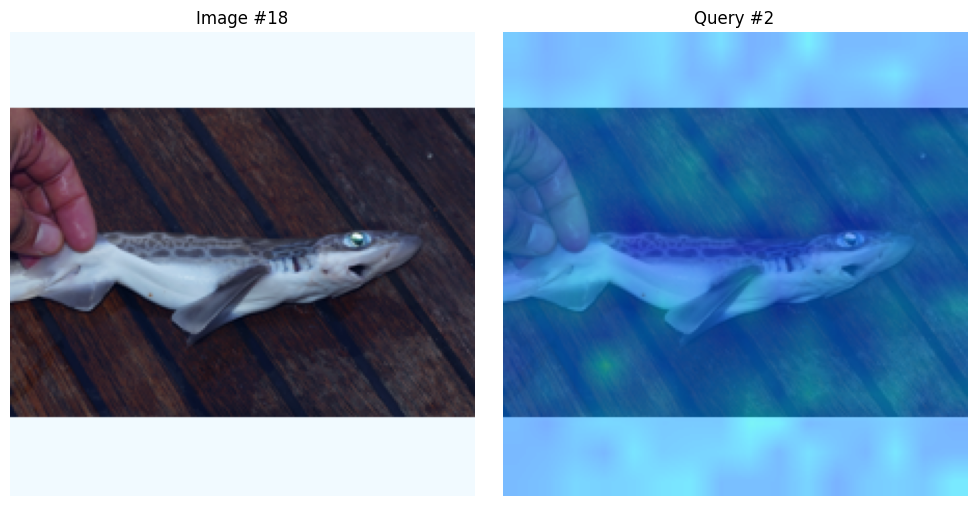

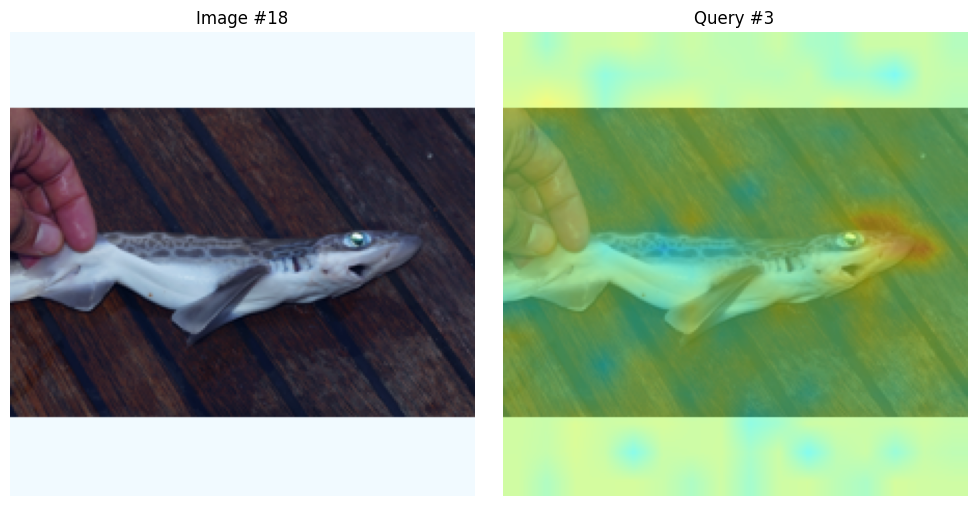

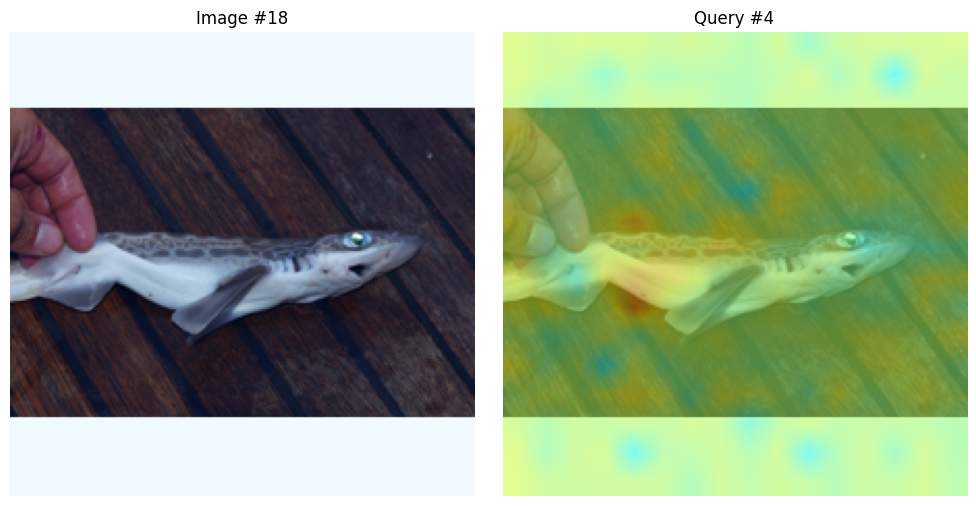

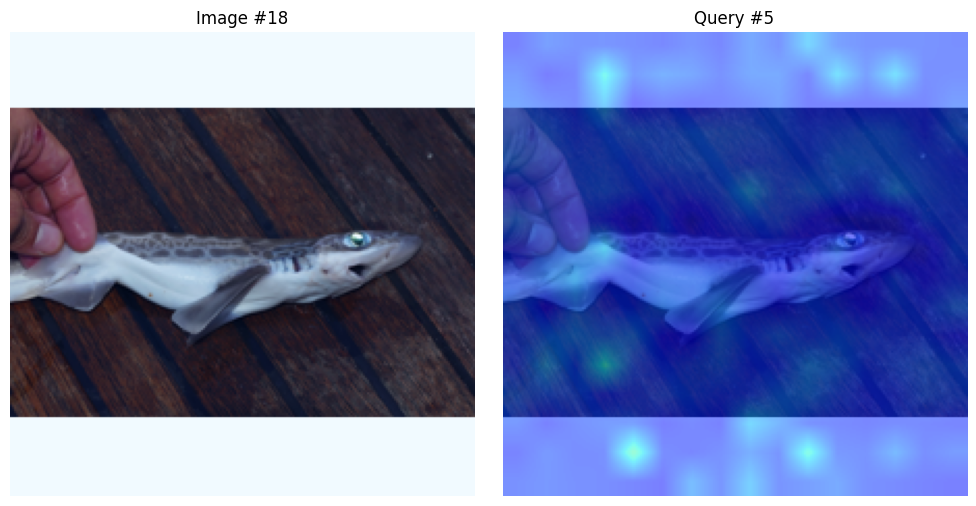

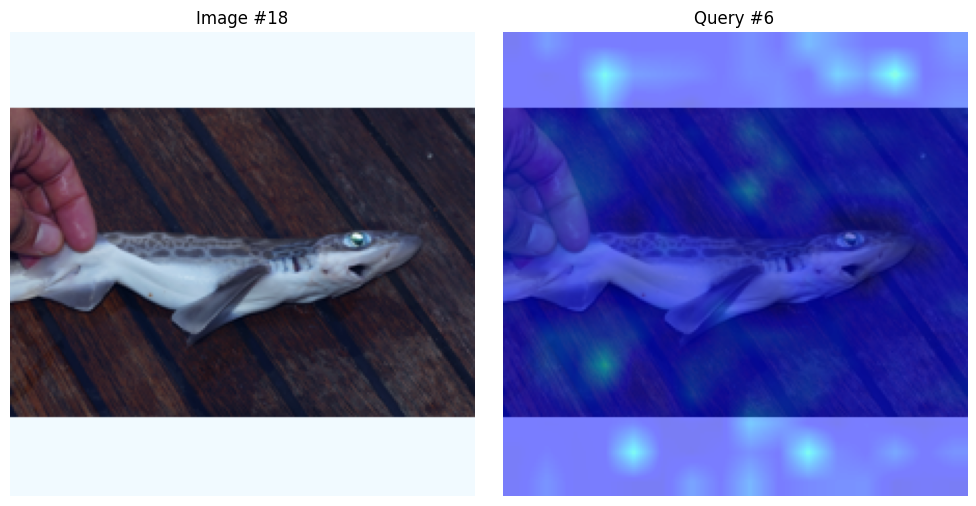

In [20]:
show_att(A_weight, imagenes_reales, image_id=18)        

In [21]:
A_weight_max = A_weight.max(dim=1).values

def normalize_maps(A):
    A_min = A.min(dim=1, keepdim=True).values
    A_max = A.max(dim=1, keepdim=True).values
    return (A - A_min) / (A_max - A_min + 1e-8)

A_weight_max_norm = normalize_maps(A_weight_max)

In [22]:
def _to_pil(img, size):
    if isinstance(img, torch.Tensor):
        img = img.detach().cpu()
        if img.ndim == 3 and img.shape[0] in (1, 3):
            img = img.permute(1, 2, 0).numpy()
        else:
            img = img.numpy()
    if isinstance(img, np.ndarray):
        if img.dtype != np.uint8:
            img = (np.clip(img, 0, 1) * 255).astype(np.uint8)
        img = Image.fromarray(img)
    return img.resize((size, size))

def show_att_one(A_single, real_images, image_id=0, size=224, cmap='jet'):
    A = torch.stack(A_single) if isinstance(A_single, list) else A_single
    image_id = max(0, min(int(image_id), A.shape[0]-1, len(real_images)-1))
    N = A.shape[1]
    mesh = int(math.isqrt(N))
    vmin, vmax = A.min().item(), A.max().item()
    img_pil = _to_pil(real_images[image_id], size)
    att = A[image_id].detach().float().cpu().reshape(mesh, mesh)
    att_resized = F.interpolate(att[None, None], size=(size, size), mode='bilinear', align_corners=False).squeeze().numpy()
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(img_pil); axs[0].set_title(f"Image #{image_id}"); axs[0].axis('off')
    axs[1].imshow(img_pil); im = axs[1].imshow(att_resized, cmap=cmap, alpha=0.5, vmin=vmin, vmax=vmax)
    axs[1].set_title("Max-reduced attention"); axs[1].axis('off')

    plt.tight_layout()
    plt.show()


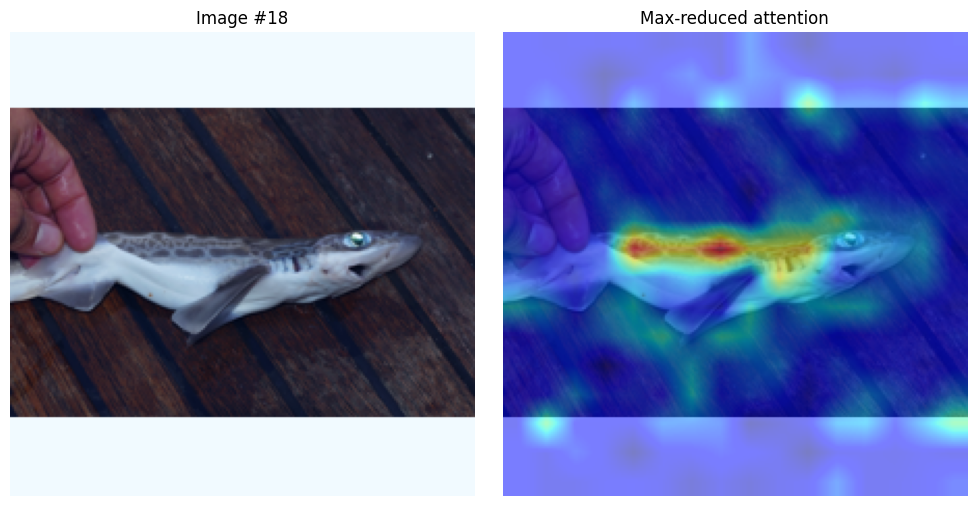

In [23]:
show_att_one(A_weight_max_norm**2, imagenes_reales, image_id=18, size=224, cmap='jet')

In [24]:
batch_images = torch.cat(imagens_tensor, dim=0)

# Re-executing CLIP with bias

In [25]:

clip_inres = model.visual.input_resolution
clip_ksize = model.visual.conv1.kernel_size

def _proj_after_ln_post(x):
    if getattr(model.visual, "proj", None) is not None:
        return x @ model.visual.proj
    return x

def _attn_block(TR, x):
    x_in = x
    x = TR.ln_1(x_in)
    q, k, v = F.linear(x, TR.attn.in_proj_weight, TR.attn.in_proj_bias).chunk(3, -1)
    N, B, D = q.shape
    h = TR.attn.num_heads
    d = D // h
    s = d ** -0.5
    q = (q * s).contiguous().view(N, B, h, d).permute(1, 2, 0, 3)
    k = k.contiguous().view(N, B, h, d).permute(1, 2, 0, 3)
    v = v.contiguous().view(N, B, h, d).permute(1, 2, 0, 3)
    attn = torch.matmul(q, k.transpose(-2, -1)).softmax(-1)
    out = torch.matmul(attn, v).permute(2, 0, 1, 3).contiguous().view(N, B, D)
    out = F.linear(out, TR.attn.out_proj.weight, TR.attn.out_proj.bias)
    x = x_in + out
    x = x + TR.mlp(TR.ln_2(x))
    return x

def _attn_block_with_boost(TR, x, key_bias):
    x_in = x
    x = TR.ln_1(x_in)
    q, k, v = F.linear(x, TR.attn.in_proj_weight, TR.attn.in_proj_bias).chunk(3, -1)
    N, B, D = q.shape
    h = TR.attn.num_heads
    d = D // h
    s = d ** -0.5
    q = (q * s).contiguous().view(N, B, h, d).permute(1, 2, 0, 3)
    k = k.contiguous().view(N, B, h, d).permute(1, 2, 0, 3)
    v = v.contiguous().view(N, B, h, d).permute(1, 2, 0, 3)
    attn = torch.matmul(q, k.transpose(-2, -1))
    attn = attn + key_bias
    attn = attn.softmax(-1)
    out = torch.matmul(attn, v).permute(2, 0, 1, 3).contiguous().view(N, B, D)
    
    out = F.linear(out, TR.attn.out_proj.weight, TR.attn.out_proj.bias)
    x = x_in + out
    x = x + TR.mlp(TR.ln_2(x))
    return x

def _select_layers(n_layers, last_n=None, indices=None):
    if indices is not None:
        return set(i for i in indices if 0 <= i < n_layers)
    if last_n is not None:
        last_n = max(0, min(last_n, n_layers))
        return set(range(n_layers - last_n, n_layers))
    return set(range(n_layers))

def replicator_clip_boost(X, patch_weights, boost=2.0, invert=False, last_n=None, indices=None):
    device = next(model.parameters()).device
    X = X.to(device)
    x = model.visual.conv1(X.half())
    feah, feaw = x.shape[-2:]
    w = patch_weights.view(x.shape[0], -1)

    if invert:
        w = 1.0 - w  

    x = x.reshape(x.shape[0], x.shape[1], -1).permute(0, 2, 1)
    cls_tok = model.visual.class_embedding.to(x.dtype)
    x = torch.cat([cls_tok + torch.zeros(x.size(0), 1, x.size(-1), device=x.device, dtype=x.dtype), x], 1)
    pos = model.visual.positional_embedding.to(x.dtype)
    tok_pos, img_pos = pos[:1], pos[1:]
    pos_h, pos_w = clip_inres // clip_ksize[0], clip_inres // clip_ksize[1]
    img_pos = img_pos.view(1, pos_h, pos_w, -1).permute(0, 3, 1, 2)
    img_pos = F.interpolate(img_pos, (feah, feaw), mode='bicubic', align_corners=False)
    img_pos = img_pos.view(1, img_pos.size(1), -1).permute(0, 2, 1)
    pos_full = torch.cat([tok_pos[None, ...], img_pos], 1)
    x = model.visual.ln_pre(x + pos_full)
    x = x.permute(1, 0, 2)
    B = x.shape[1]

    # aquí cambia: ya no booleano, sino pesos continuos
    w_full = torch.cat([torch.zeros(x.size(1), 1, device=x.device, dtype=x.dtype), w.to(x.dtype)], dim=1)
    key_bias = w_full[:, None, None, :]

    blocks = model.visual.transformer.resblocks
    sel = _select_layers(len(blocks), last_n=last_n, indices=indices)
    for i, TR in enumerate(blocks):
        if i in sel:
            x = _attn_block_with_boost(TR, x, key_bias)
        else:
            x = _attn_block(TR, x)
    x = model.visual.ln_post(x.permute(1, 0, 2))
    x = _proj_after_ln_post(x)
    return x

In [26]:


labels_shark_True = [label.lower() for label in labels_shark]
w_trans = A_weight_max_norm.pow(2)      
indices = [None, 4, 3, 2, 1]
base_w = w_trans.clone()

results_by_index = {}
best_overall = {"idx": None, "factor": None, "balanced_acc": -1.0, "acc": -1.0, "preds": None}

for idx in tqdm(indices):
    results_by_index[idx] = []
    for factor in [i * 0.1 for i in range(1, int(2 / 0.1) + 1)]:      
        w_scaled = base_w * factor
        with torch.no_grad():
            img_embedding = replicator_clip_boost(batch_images, w_scaled, invert=False, indices=None, last_n=idx)
            out = F.normalize(img_embedding, dim=-1)
            img_embedding = out[:, 0]

            levels = ["Animal", "Order", "Family", "Our_Name"]
            label_animal = ["shark", "stingray"]

            final_results = []
            for image in img_embedding:
                result_image = []
                img_norm = image / image.norm()

                shark_emb = encoded_dict["shark"][0]["text_embedding"].flatten()
                stingray_emb = encoded_dict["stingray"][0]["text_embedding"].flatten()
                sims_animal = (img_norm @ torch.stack([shark_emb, stingray_emb]).T).squeeze(0)
                result_image.append(label_animal[sims_animal.argmax().item()])

                i = 0
                while i < len(levels) - 1:
                    next_level = df_taxonomy.loc[df_taxonomy[levels[i]] == result_image[-1], levels[i + 1]].unique().tolist()
                    if len(next_level) == 1:
                        result_image.append(next_level[0])
                        i += 1
                        continue
                    embs_text = torch.stack([encoded_dict[k][0]["text_embedding"].flatten() for k in next_level])
                    sims = (img_norm @ embs_text.T).squeeze(0)
                    result_image.append(next_level[sims.argmax().item()])
                    i += 1

                final_results.append(result_image)

            col = [row[3] for row in final_results]
            bacc = balanced_accuracy_score(labels_shark_adt, col)
            acc = accuracy_score(labels_shark_adt, col)

            rec = {"factor": factor, "preds": col, "balanced_acc": float(bacc), "acc": float(acc)}
            results_by_index[idx].append(rec)

            if (bacc > best_overall["balanced_acc"]) or (bacc == best_overall["balanced_acc"] and acc > best_overall["acc"]):
                best_overall = {"idx": idx, "factor": factor, "balanced_acc": float(bacc), "acc": float(acc), "preds": col}

best_per_index = {k: max(v, key=lambda r: (r["balanced_acc"], r["acc"])) if len(v) > 0 else None for k, v in results_by_index.items()}

print("Best overall:", best_overall)
print("Best per index:", {k: {"factor": x["factor"], "balanced_acc": x["balanced_acc"], "acc": x["acc"]} if x is not None else None for k, x in best_per_index.items()})



100%|██████████| 5/5 [39:30<00:00, 474.08s/it]

Best overall: {'idx': 1, 'factor': 1.1, 'balanced_acc': 0.6421244347560137, 'acc': 0.6272321428571429, 'preds': ['bocanegra', 'bocanegra', 'cerdo_marino', 'cerdo_marino', 'bocanegra', 'pintarroja', 'bocanegra', 'bocanegra', 'bocanegra', 'musola', 'bocanegra', 'musola', 'bocanegra', 'pintarroja', 'cerdo_marino', 'musola', 'bocanegra', 'pintarroja', 'bocanegra', 'musola', 'bocanegra', 'bocanegra', 'bocanegra', 'pintarroja', 'pintarroja', 'bocanegra', 'bocanegra', 'bocanegra', 'bocanegra', 'bocanegra', 'musola', 'bocanegra', 'cerdo_marino', 'pintarroja', 'bocanegra', 'bocanegra', 'bocanegra', 'cazon', 'cazon', 'cazon', 'musola', 'cazon', 'cazon', 'cazon', 'cerdo_marino', 'cazon', 'cazon', 'musola', 'musola', 'musola', 'cerdo_marino', 'cazon', 'bocanegra', 'bocanegra', 'bocanegra', 'cazon', 'cerdo_marino', 'cerdo_marino', 'musola', 'musola', 'musola', 'cazon', 'cazon', 'cerdo_marino', 'musola', 'cazon', 'cerdo_marino', 'musola', 'musola', 'musola', 'bocanegra', 'cazon', 'musola', 'cazon', 

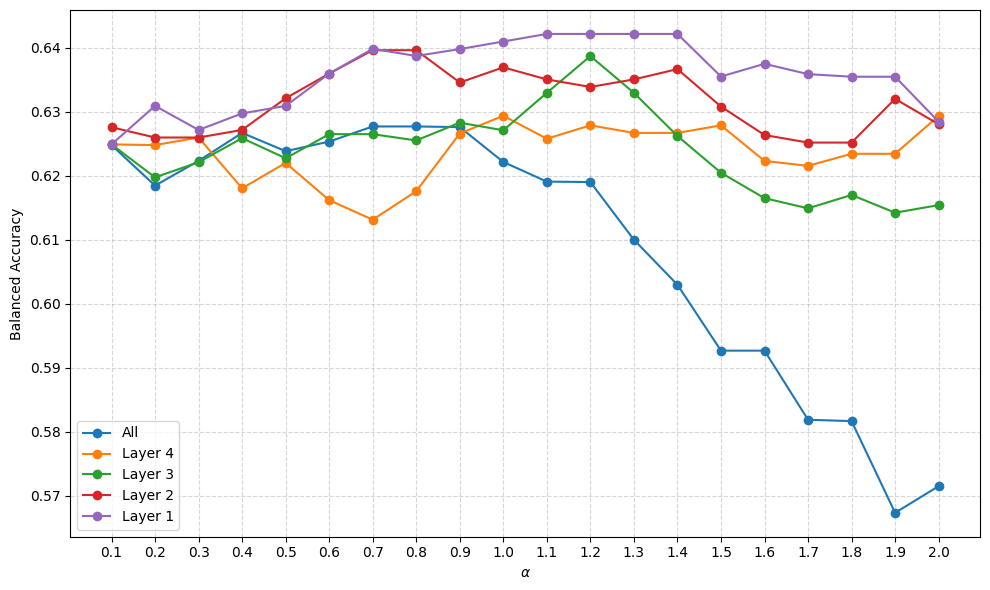

In [27]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot Balanced Accuracy vs Alpha for each layer
for layer, records in results_by_index.items():
    if not records:
        continue
    alphas = [r["factor"] for r in records]
    baccs = [r["balanced_acc"] for r in records]
    label = f"Layer {layer}" if layer is not None else "All"
    plt.plot(alphas, baccs, marker='o', label=label)

plt.xlabel(r"$\alpha$")
plt.ylabel("Balanced Accuracy")
plt.xticks([i * 0.1 for i in range(1, 21)])
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


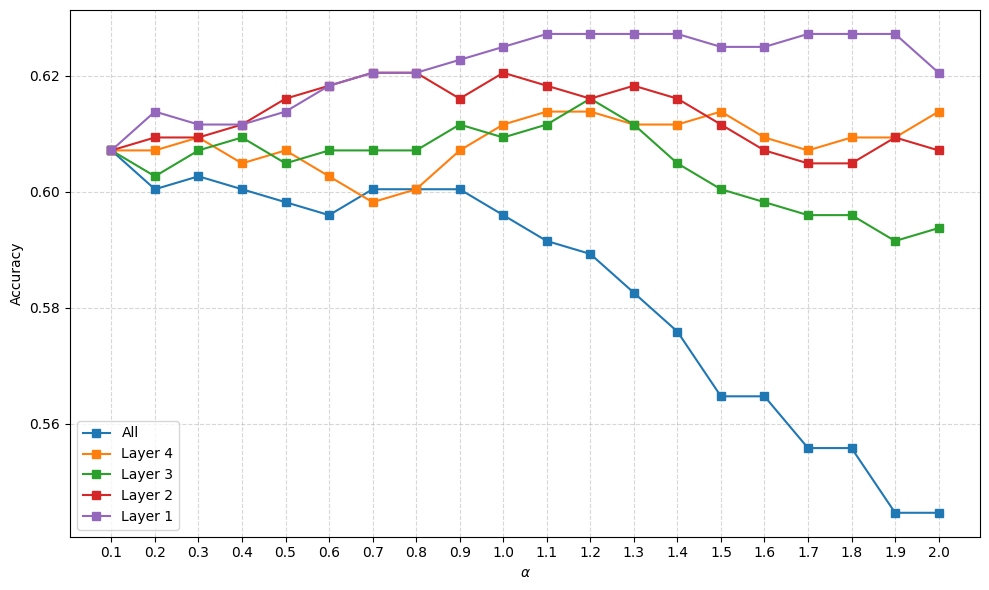

In [28]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot Accuracy vs Alpha for each layer
for layer, records in results_by_index.items():
    if not records:
        continue
    alphas = [r["factor"] for r in records]
    accs = [r["acc"] for r in records]
    label = f"Layer {layer}" if layer is not None else "All"
    plt.plot(alphas, accs, marker='s', label=label)

plt.xlabel(r"$\alpha$")
plt.ylabel("Accuracy")
plt.xticks([i * 0.1 for i in range(1, 21)])
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


## Prompt with taxonomy-aware sequential classification combined with CLIP attention bias across all levels

In [29]:
w_trans = A_weight_max_norm.pow(2)       

In [30]:
with torch.no_grad():
  img_embedding = replicator_clip_boost(batch_images, w_trans*1.4, invert=False, indices=None, last_n=1)
print(img_embedding.size())
out = F.normalize(img_embedding, dim=-1)
img_embedding = out[:, 0]


torch.Size([448, 257, 768])


In [31]:
levels=["Animal","Order","Family","Our_Name"]
label_animal=["shark","stingray"]

final_results=[]

for image in (img_embedding):
    result_image=[]
    
    img_norm = image / image.norm(dim=-1, keepdim=True)
    
    shark_emb = encoded_dict["shark"][0]["text_embedding"].flatten()
    stingray_emb = encoded_dict["stingray"][0]["text_embedding"].flatten()
    
    sims_animal = (img_norm @ torch.stack([shark_emb, stingray_emb]).T).squeeze(0)
    result_image.append(label_animal[sims_animal.argmax().item()])
    
    i=0
    while i<len(levels)-1:     
        next_level = df_taxonomy.loc[df_taxonomy[levels[i]] == result_image[-1], levels[i+1]].unique().tolist()
        if len(next_level) == 1:
            result_image.append(next_level[0])
            i += 1
            continue         
        embs_text = torch.stack([encoded_dict[k][0]["text_embedding"].flatten() for k in next_level])        
        sims = (img_norm @ embs_text.T).squeeze(0)
        result_image.append(next_level[sims.argmax().item()])
        i += 1

    final_results.append(result_image)


-----Animal-----
Accuracy balanced: 0.9935
Accuracy: 0.9911

Classification Report:
               precision    recall  f1-score   support

       shark       1.00      0.99      0.99       308
    stingray       0.97      1.00      0.99       140

    accuracy                           0.99       448
   macro avg       0.99      0.99      0.99       448
weighted avg       0.99      0.99      0.99       448



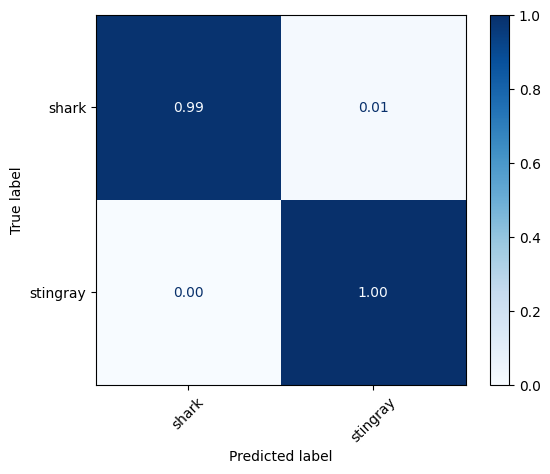


-----Order-----
Accuracy balanced: 0.8197
Accuracy: 0.8214

Classification Report:
                    precision    recall  f1-score   support

carcharhiniformes       0.98      0.82      0.89       272
     squaliformes       0.38      0.81      0.51        36
       rajiformes       0.86      0.83      0.85        90
  torpediniformes       0.72      0.82      0.77        50

         accuracy                           0.82       448
        macro avg       0.74      0.82      0.76       448
     weighted avg       0.88      0.82      0.84       448



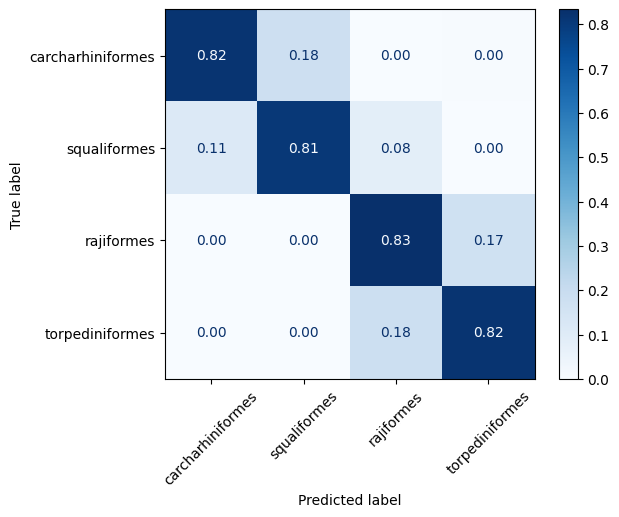


-----Family-----
Accuracy balanced: 0.7800
Accuracy: 0.7656

Classification Report:
                 precision    recall  f1-score   support

scyliorhinidae       0.92      0.77      0.84       158
     triakidae       0.80      0.68      0.73       114
    oxynotidae       0.38      0.81      0.51        36
       rajidae       0.86      0.83      0.85        90
  torpedinidae       0.72      0.82      0.77        50

      accuracy                           0.77       448
     macro avg       0.74      0.78      0.74       448
  weighted avg       0.81      0.77      0.78       448



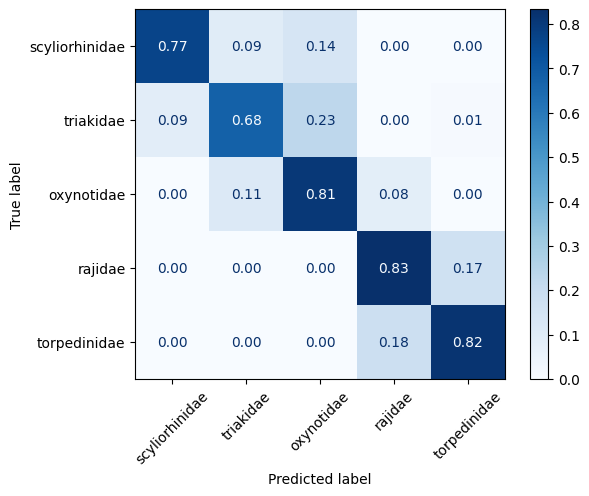


-----Our_Name-----
Accuracy balanced: 0.6421
Accuracy: 0.6272

Classification Report:
               precision    recall  f1-score   support

   bocanegra       0.32      0.59      0.42        37
       cazon       0.62      0.42      0.50        38
cerdo_marino       0.38      0.81      0.51        36
      musola       0.61      0.57      0.59        76
  pintarroja       0.87      0.45      0.60       121
 santiaguesa       0.86      0.83      0.85        90
  tembladera       0.72      0.82      0.77        50

    accuracy                           0.63       448
   macro avg       0.63      0.64      0.60       448
weighted avg       0.70      0.63      0.64       448



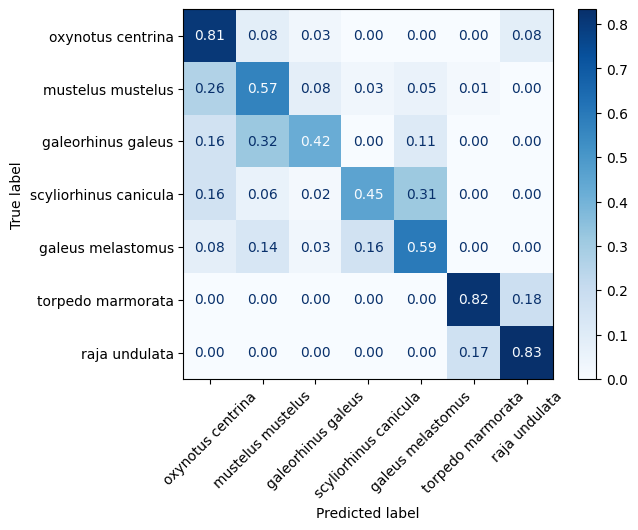

In [32]:
labels_shark_True = [label.lower() for label in labels_shark]

desired_order_display = [
    "oxynotus centrina",
    "mustelus mustelus",
    "galeorhinus galeus",
    "scyliorhinus canicula",
    "galeus melastomus",
    "torpedo marmorata",
    "raja undulata"
]
typo_fix = {

}


for v, lv in enumerate(levels):
    col = [row[v] for row in final_results]
    name_to_level = dict(zip(df["Our_Name"], df[lv]))
    labels_shark_adt = [name_to_level[name] for name in labels_shark_True]

    print("-----" + lv + "-----")
    acc = balanced_accuracy_score(labels_shark_adt, col)
    print(f"Accuracy balanced: {acc:.4f}")
    acc = accuracy_score(labels_shark_adt, col)
    print(f"Accuracy: {acc:.4f}")
    report = classification_report(
        labels_shark_adt,
        col,
        labels=df[lv].drop_duplicates().to_list(),
        zero_division=0
    )
    print("\nClassification Report:\n", report)

    if v == len(levels) - 1:
        level_to_scientific = dict(zip(df[lv], df["Scientific Name"]))
        scientific_to_level = {s: l for l, s in level_to_scientific.items()}

        desired_order_corrected = [typo_fix.get(s, s) for s in desired_order_display]
        ordered_lv_labels = [scientific_to_level[s] for s in desired_order_corrected]

        cm = confusion_matrix(
            labels_shark_adt,
            col,
            labels=ordered_lv_labels,
            normalize="true"
        )
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=desired_order_display)
    else:
        cm = confusion_matrix(
            labels_shark_adt,
            col,
            labels=df[lv].drop_duplicates().to_list(),
            normalize="true"
        )
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=df[lv].drop_duplicates().to_list())

    disp.plot(cmap="Blues", xticks_rotation=45, values_format=".2f")
    plt.show()
    print()


## Prompt with taxonomy-aware sequential classification combined with CLIP attention bias applied only at the family and species level

In [33]:
levels=["Animal","Order","Family","Our_Name"]
label_animal=["shark","stingray"]

final_results=[]

for feat_img, img_emb in zip(feature_image, img_embedding):
    
    result_image=[]
    
    img_norm = feat_img / feat_img.norm(dim=-1, keepdim=True)
    img_emb_norm= img_emb / img_emb.norm(dim=-1, keepdim=True)
    
    shark_emb = encoded_dict["shark"][0]["text_embedding"].flatten()
    stingray_emb = encoded_dict["stingray"][0]["text_embedding"].flatten()
    
    sims_animal = (img_norm @ torch.stack([shark_emb, stingray_emb]).T).squeeze(0)
    result_image.append(label_animal[sims_animal.argmax().item()])
    
    i=0
    while i<len(levels)-1:     
        next_level = df_taxonomy.loc[df_taxonomy[levels[i]] == result_image[-1], levels[i+1]].unique().tolist()
        if len(next_level) == 1:
            result_image.append(next_level[0])
            i += 1
            continue      
           
        if levels[i+1] == "Our_Name" or levels[i+1] == "Family":
            img_norm = img_emb_norm
            
        embs_text = torch.stack([encoded_dict[k][0]["text_embedding"].flatten() for k in next_level])        
        sims = (img_norm @ embs_text.T).squeeze(0)
        result_image.append(next_level[sims.argmax().item()])
        i += 1

    final_results.append(result_image)


-----Animal-----
Accuracy balanced: 0.9880
Accuracy: 0.9888

Classification Report:
               precision    recall  f1-score   support

       shark       0.99      0.99      0.99       308
    stingray       0.98      0.99      0.98       140

    accuracy                           0.99       448
   macro avg       0.99      0.99      0.99       448
weighted avg       0.99      0.99      0.99       448



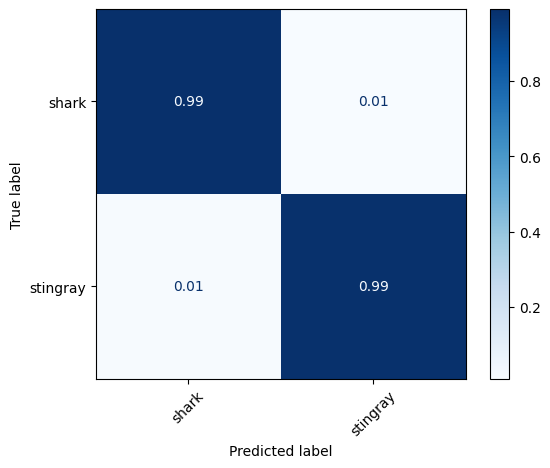


-----Order-----
Accuracy balanced: 0.8277
Accuracy: 0.8214

Classification Report:
                    precision    recall  f1-score   support

carcharhiniformes       0.99      0.82      0.89       272
     squaliformes       0.38      0.86      0.53        36
       rajiformes       0.86      0.83      0.85        90
  torpediniformes       0.74      0.80      0.77        50

         accuracy                           0.82       448
        macro avg       0.74      0.83      0.76       448
     weighted avg       0.89      0.82      0.84       448



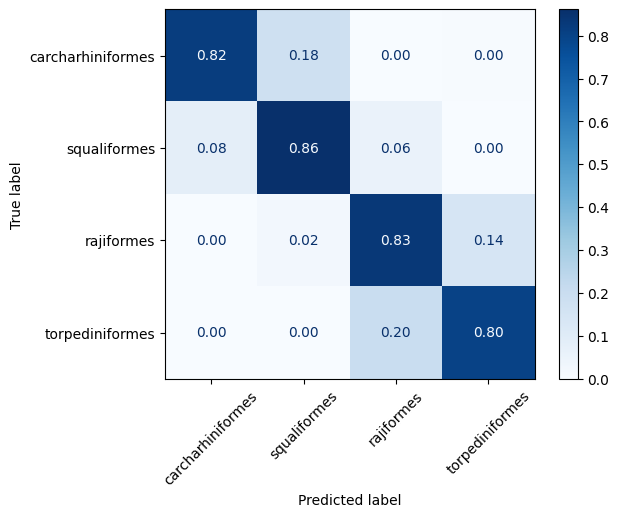


-----Family-----
Accuracy balanced: 0.7864
Accuracy: 0.7656

Classification Report:
                 precision    recall  f1-score   support

scyliorhinidae       0.92      0.75      0.83       158
     triakidae       0.81      0.68      0.74       114
    oxynotidae       0.38      0.86      0.53        36
       rajidae       0.86      0.83      0.85        90
  torpedinidae       0.74      0.80      0.77        50

      accuracy                           0.77       448
     macro avg       0.74      0.79      0.74       448
  weighted avg       0.82      0.77      0.78       448



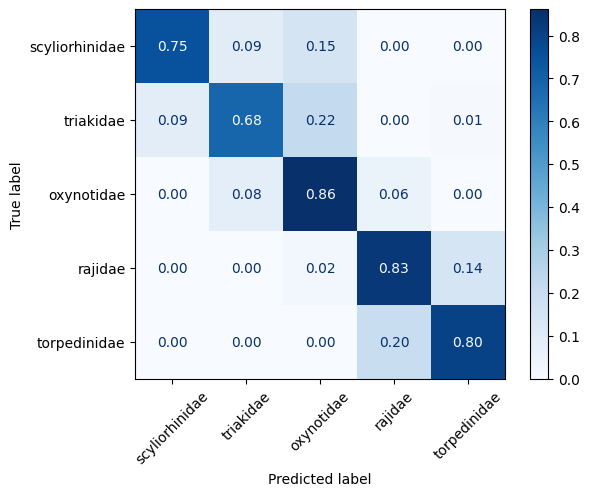


-----Our_Name-----
Accuracy balanced: 0.6432
Accuracy: 0.6272

Classification Report:
               precision    recall  f1-score   support

   bocanegra       0.30      0.54      0.39        37
       cazon       0.65      0.45      0.53        38
cerdo_marino       0.38      0.86      0.53        36
      musola       0.61      0.57      0.59        76
  pintarroja       0.87      0.45      0.60       121
 santiaguesa       0.86      0.83      0.85        90
  tembladera       0.74      0.80      0.77        50

    accuracy                           0.63       448
   macro avg       0.63      0.64      0.61       448
weighted avg       0.71      0.63      0.64       448



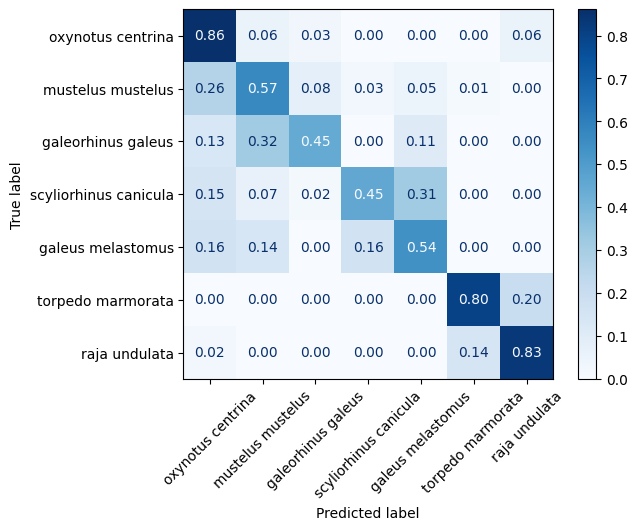

In [34]:
labels_shark_True = [label.lower() for label in labels_shark]

desired_order_display = [
    "oxynotus centrina",
    "mustelus mustelus",
    "galeorhinus galeus",
    "scyliorhinus canicula",
    "galeus melastomus",
    "torpedo marmorata",
    "raja undulata"
]

typo_fix = {

}

for v, lv in enumerate(levels):
    col = [row[v] for row in final_results]
    name_to_level = dict(zip(df["Our_Name"], df[lv]))
    labels_shark_adt = [name_to_level[name] for name in labels_shark_True]

    print("-----" + lv + "-----")
    acc = balanced_accuracy_score(labels_shark_adt, col)
    print(f"Accuracy balanced: {acc:.4f}")
    acc = accuracy_score(labels_shark_adt, col)
    print(f"Accuracy: {acc:.4f}")
    report = classification_report(
        labels_shark_adt,
        col,
        labels=df[lv].drop_duplicates().to_list(),
        zero_division=0
    )
    print("\nClassification Report:\n", report)

    if v == len(levels) - 1:
        level_to_scientific = dict(zip(df[lv], df["Scientific Name"]))
        scientific_to_level = {s: l for l, s in level_to_scientific.items()}

        desired_order_corrected = [typo_fix.get(s, s) for s in desired_order_display]
        ordered_lv_labels = [scientific_to_level[s] for s in desired_order_corrected]

        cm = confusion_matrix(
            labels_shark_adt,
            col,
            labels=ordered_lv_labels,
            normalize="true"
        )
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=desired_order_display)
    else:
        cm = confusion_matrix(
            labels_shark_adt,
            col,
            labels=df[lv].drop_duplicates().to_list(),
            normalize="true"
        )
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=df[lv].drop_duplicates().to_list())

    disp.plot(cmap="Blues", xticks_rotation=45, values_format=".2f")
    plt.show()
    print()


## Prompt with taxonomy-aware cumulative classification combined with CLIP attention bias across all levels

In [35]:
from prompts.prompts_general import prompts_Animal, prompts_Order, prompts_Family, prompts_Our_Name

all_prompts = {
    "Animal": prompts_Animal,
    "Order": prompts_Order,
    "Family": prompts_Family,
    "Our_Name": prompts_Our_Name,
}

encoded_dict_general = {}

model.eval()

for group_key, prompt_dict in all_prompts.items():
    encoded_dict_general[group_key] = defaultdict(list)
    for key, descriptions in prompt_dict.items():
        if not descriptions:
            continue
        text_inputs = clip.tokenize(descriptions).to(device)
        with torch.no_grad():
            text_feats = model.encode_text(text_inputs)
            text_feats = text_feats / text_feats.norm(dim=-1, keepdim=True)
        for desc, feat in zip(descriptions, text_feats):
            encoded_dict_general[group_key][key].append({
                "description": desc,
                "text_embedding": feat.detach().clone()
            })
    encoded_dict_general[group_key] = dict(encoded_dict_general[group_key])


In [36]:
stacked_by_level = {}

for lvl, d in encoded_dict_general.items():
    all_embs = []
    for k, lst in d.items():
        for x in lst:
            all_embs.append(x["text_embedding"].flatten())
    stacked_by_level[lvl] = torch.stack(all_embs) if all_embs else torch.empty(0)

In [37]:
import torch

final_results = []

levels = ["Animal","Order","Family","Our_Name"]
labels_by_level = {
 'Animal': ['shark', 'stingray'],
 'Order': ['carcharhiniformes', 'squaliformes', 'torpediniformes', 'rajiformes'],
 'Family': ['scyliorhinidae', 'triakidae', 'oxynotidae', 'rajidae', 'torpedinidae'],
 'Our_Name': ['bocanegra', 'cazon', 'cerdo_marino', 'musola', 'pintarroja', 'santiaguesa', 'tembladera']
}

index_maps = {lvl: {lab: i for i, lab in enumerate(labels_by_level[lvl])} for lvl in levels}

species_positions = [
    [index_maps[lvl][df.iloc[r][lvl]] for lvl in levels]
    for r in range(len(df))
]
n_cols = len(species_positions[0])

for image in img_embedding:
    image_tax = []
    sims_image = []
    img_norm = image / image.norm(dim=-1, keepdim=True)
    for level in levels:
        mat = stacked_by_level[level]
        sims = img_norm @ mat.T
        sims_image.append(sims)

    for c in range(n_cols):
        scores = []
        for row in species_positions:
            pos = row[:c+1]
            total = sum(sims_image[i][pos[i]] for i in range(c+1))
            scores.append(total)
        scores = torch.stack(scores)
        idx_best = int(torch.argmax(scores).item())
        image_tax.append(df.iloc[idx_best][levels[c]])

    final_results.append(image_tax)


-----Animal-----
Accuracy balanced: 0.9935
Accuracy: 0.9911

Classification Report:
               precision    recall  f1-score   support

       shark       1.00      0.99      0.99       308
    stingray       0.97      1.00      0.99       140

    accuracy                           0.99       448
   macro avg       0.99      0.99      0.99       448
weighted avg       0.99      0.99      0.99       448



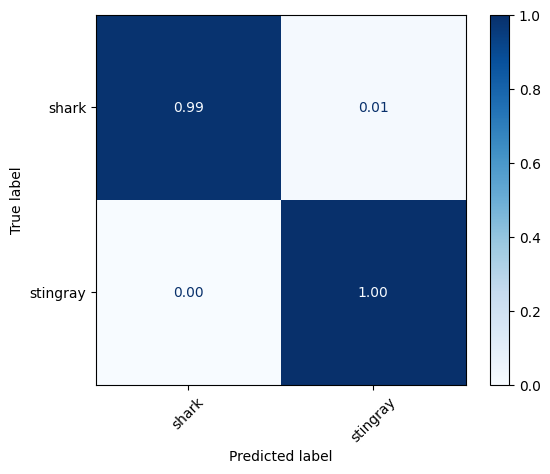


-----Order-----
Accuracy balanced: 0.8118
Accuracy: 0.8170

Classification Report:
                    precision    recall  f1-score   support

carcharhiniformes       0.98      0.82      0.89       272
     squaliformes       0.36      0.78      0.49        36
       rajiformes       0.85      0.83      0.84        90
  torpediniformes       0.73      0.82      0.77        50

         accuracy                           0.82       448
        macro avg       0.73      0.81      0.75       448
     weighted avg       0.88      0.82      0.84       448



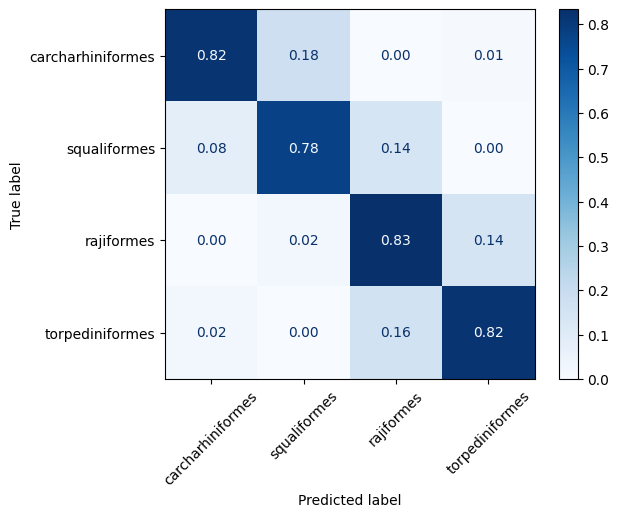


-----Family-----
Accuracy balanced: 0.7785
Accuracy: 0.7946

Classification Report:
                 precision    recall  f1-score   support

scyliorhinidae       0.90      0.80      0.85       158
     triakidae       0.77      0.78      0.77       114
    oxynotidae       0.47      0.64      0.54        36
       rajidae       0.88      0.86      0.87        90
  torpedinidae       0.75      0.82      0.78        50

      accuracy                           0.79       448
     macro avg       0.75      0.78      0.76       448
  weighted avg       0.81      0.79      0.80       448



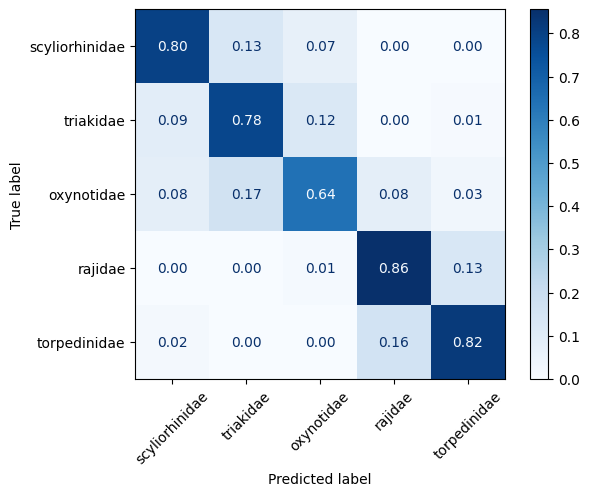


-----Our_Name-----
Accuracy balanced: 0.6294
Accuracy: 0.5915

Classification Report:
               precision    recall  f1-score   support

   bocanegra       0.27      0.73      0.39        37
       cazon       0.44      0.53      0.48        38
cerdo_marino       0.70      0.58      0.64        36
      musola       0.51      0.66      0.57        76
  pintarroja       0.83      0.21      0.33       121
 santiaguesa       0.84      0.92      0.88        90
  tembladera       0.85      0.78      0.81        50

    accuracy                           0.59       448
   macro avg       0.63      0.63      0.59       448
weighted avg       0.69      0.59      0.58       448



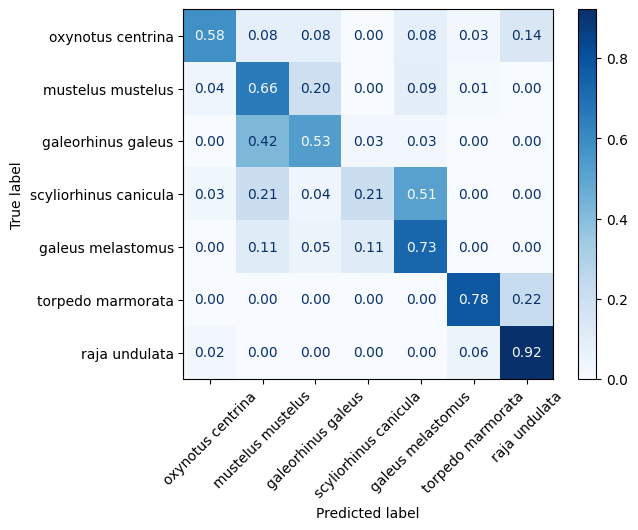

In [38]:
labels_shark_True = [label.lower() for label in labels_shark]

desired_order_display = [
    "oxynotus centrina",
    "mustelus mustelus",
    "galeorhinus galeus",
    "scyliorhinus canicula",
    "galeus melastomus",
    "torpedo marmorata",
    "raja undulata"
]

typo_fix = {

}

for v, lv in enumerate(levels):
    col = [row[v] for row in final_results]
    name_to_level = dict(zip(df["Our_Name"], df[lv]))
    labels_shark_adt = [name_to_level[name] for name in labels_shark_True]

    print("-----" + lv + "-----")
    acc = balanced_accuracy_score(labels_shark_adt, col)
    print(f"Accuracy balanced: {acc:.4f}")
    acc = accuracy_score(labels_shark_adt, col)
    print(f"Accuracy: {acc:.4f}")
    report = classification_report(
        labels_shark_adt,
        col,
        labels=df[lv].drop_duplicates().to_list(),
        zero_division=0
    )
    print("\nClassification Report:\n", report)

    if v == len(levels) - 1:
        level_to_scientific = dict(zip(df[lv], df["Scientific Name"]))
        scientific_to_level = {s: l for l, s in level_to_scientific.items()}

        desired_order_corrected = [typo_fix.get(s, s) for s in desired_order_display]
        ordered_lv_labels = [scientific_to_level[s] for s in desired_order_corrected]

        cm = confusion_matrix(
            labels_shark_adt,
            col,
            labels=ordered_lv_labels,
            normalize="true"
        )
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=desired_order_display)
    else:
        cm = confusion_matrix(
            labels_shark_adt,
            col,
            labels=df[lv].drop_duplicates().to_list(),
            normalize="true"
        )
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=df[lv].drop_duplicates().to_list())

    disp.plot(cmap="Blues", xticks_rotation=45, values_format=".2f")
    plt.show()
    print()
